Sorting numbers using a neural network sounds weird and feels wrong. The main reason is that we already have deterministic, efficient, and provably correct algorithms that do can sort any sequence of real numbers. Nevertheless, it is a good exercise to explore whether and how neural networks can learn to sort: how should the data look like, what kind of architecture, does the network learn reasonable embeddings etc. This is an active research field, mainly used to understand the NN representation power, e.g., https://research.google/blog/understanding-transformer-reasoning-capabilities-via-graph-algorithms/.



We will experiment with transformer models. Given that a sorted list of nubmers is a sequence, it makes sense to use a sequence-to-sequence model where the input is an unordered sequence of numbers and the output is the sorted sequence. The encoder should encode the input and the decoder generates the ordered sequence.    

In [ ]:
!pip install rotary-embedding-torch
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.6 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import math
import numpy as np

First we create the data which are the unordered sequence as context, the ordered sequence with the start symbol as input (we use 0), and the ordered sequence with the end symbol as output (we use the size of the vocabulary). In addition, we use a padding token (size of vocabulary + 1).

In [ ]:
from torch.utils.data import DataLoader

# Data generation with variable sequence lengths
def generate_data(n, max_seq_len, vocab_size,vary_sec_len=True, n_sorted_input=None, n_rep=None):
    data = []
    seq_len = max_seq_len

    for _ in range(n):
        if vary_sec_len:
          seq_len = np.random.randint(2, max_seq_len+1,1)  # Random sequence length between 2 and max_seq_len
        seq = np.random.randint(1, vocab_size, seq_len)  # Random sequence between 1 and vocab_size
        sorted_seq = np.sort(seq)
        data.append((seq, sorted_seq))

    if n_sorted_input is not None:
      for i in range(n_sorted_input):
        if vary_sec_len:
            seq_len = np.random.randint(2, max_seq_len+1,1)
        seq = np.random.randint(1, vocab_size, seq_len)  # Random sequence between 1 and vocab_size
        sorted_seq = np.sort(seq)
        data.append((sorted_seq, sorted_seq))

    if n_rep is not None:
      for i in range(n_rep):
        if vary_sec_len:
            seq_len = np.random.randint(2, max_seq_len+1,1)
        num = np.random.randint(1, vocab_size, 1)  # Random sequence between 1 and vocab_size
        rep_seq = num*np.ones(seq_len)
        data.append((rep_seq, rep_seq))

    return data

# Convert data into tensors with padding for <SOS> and <EOS> tokens
def prepare_batch(batch, vocab_size):
    src_seqs = []
    tgt_seqs = []
    for src, tgt in batch:
        src_seqs.append(torch.tensor(src, dtype=torch.long))
        tgt_seqs.append(torch.tensor([0] + list(tgt) + [vocab_size], dtype=torch.long))  # 0 = <SOS>, vocab_size = <EOS>

    # Pad sequences to the same length
    src_padded = nn.utils.rnn.pad_sequence(src_seqs, batch_first=True, padding_value=vocab_size + 1)  # Padding for src
    tgt_padded = nn.utils.rnn.pad_sequence(tgt_seqs, batch_first=True, padding_value=vocab_size + 1)  # Padding for tgt

    return src_padded, tgt_padded[:, :-1], tgt_padded[:, 1:]  # tgt_input, tgt_output



There are multiple design choices for sorting numbers that I had to try out. Some of them are whether there is a sequence encoder or a regular non-linear encoder, and whether there is a encoder in the first place, e.g., the token embedding can be directly used if we can manage to encode its "number-ness". Another aspect to consider is that the task considers as input an unsorted sequence of numbers which does not really have a "sequense" structure (more like a set), hence there is no need for positional encoding (i.e., treating it mostly as a Set Transformer). For positional encodings there is both sinusodial and rotatational embeddings. There is the option to encode the input either with a transformer model (i.e., use attention), a non-linear encoder (i.e., a regular MLP), or simply use the nn.Embedding vectors.


In [ ]:
from operator import add
import torch
import torch.nn as nn
import torch.nn.functional as F
from rotary_embedding_torch import RotaryEmbedding


# Positional Encoding Layer
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=1001):
        super(PositionalEncoding, self).__init__()
        # Create positional encoding
        position = torch.arange(0, max_len+1).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2) * -(math.log(10000.0) / embed_dim))
        pe = torch.zeros(max_len+1, embed_dim)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)  # Shape: (1, max_len, embed_dim) # Moved to device

    def forward(self, x):
        # Ensure that positional encoding matches the input's sequence length
        x = x + self.pe[:, :x.size(1), :].to(x.device)
        return x

class NumericEmbedding(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.projection = nn.Linear(1, embed_dim)

    def forward(self, x):
        x = x.float().unsqueeze(-1)  # Shape: (batch_size, seq_len, 1)
        return self.projection(x)

class NonLinearEncoder(nn.Module):
    def __init__(self, embed_dim, ff_dim, num_layers, dropout):
        super(NonLinearEncoder, self).__init__()
        self.layers = nn.ModuleList()
        for _ in range(num_layers):
            self.layers.append(nn.Sequential(
                nn.Linear(embed_dim, ff_dim),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(ff_dim, embed_dim)
            ))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x) + x  # Residual connection
        return x

class LinearEncoder(nn.Module):
    def __init__(self, embed_dim, ff_dim, num_layers, dropout):
        super(LinearEncoder, self).__init__()
        self.layers = nn.ModuleList()
        for _ in range(num_layers):
            self.layers.append(nn.Sequential(
                nn.Linear(embed_dim, ff_dim),
                nn.Dropout(dropout),
                nn.Linear(ff_dim, embed_dim)
            ))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x) + x  # Residual connection
        return x


class TransformerDecoderLayerWithAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout, use_rotary_embeddings=False):
        super(TransformerDecoderLayerWithAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        # Attention layers
        self.self_attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.cross_attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)

        # Feedforward network
        self.feedforward = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(ff_dim, embed_dim),
        )

        # Layer norms and dropout
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.norm3 = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)

        # Rotary embedding (if enabled)
        self.use_rotary_embeddings = use_rotary_embeddings
        if self.use_rotary_embeddings:
            self.rotary_emb = RotaryEmbedding(dim=self.head_dim)

    def apply_rotary_embeddings(self, x):
        # Reshape to (batch, heads, seq_len, head_dim) for rotary embedding
        batch_size, seq_len, embed_dim = x.shape
        x = x.view(batch_size, seq_len, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        x = self.rotary_emb.rotate_queries_or_keys(x)
        return x.permute(0, 2, 1, 3).reshape(batch_size, seq_len, embed_dim)

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        # Self-attention with rotary embeddings (if enabled)
        q = k = tgt
        # print(f'tgt shape {tgt.shape}')
        if self.use_rotary_embeddings:
            q, k = self.apply_rotary_embeddings(q), self.apply_rotary_embeddings(k)
        tgt2 = self.self_attn(q, k, tgt, attn_mask=tgt_mask, key_padding_mask=tgt_key_padding_mask)[0]
        tgt = tgt + self.dropout(tgt2)
        tgt = self.norm1(tgt)

        # # Cross-attention with rotary embeddings (if enabled)
        # if self.use_rotary_embeddings:
        #     q = self.apply_rotary_embeddings(tgt)
        #     k = self.apply_rotary_embeddings(memory)
        # tgt2, attn_output_weights = self.cross_attn(q, k, memory, attn_mask=memory_mask, key_padding_mask=memory_key_padding_mask)
        # tgt = tgt + self.dropout(tgt2)
        # tgt = self.norm2(tgt)
        # Cross-attention layer with residual connection
        tgt2, attn_output_weights = self.cross_attn(tgt, memory, memory, attn_mask=memory_mask, key_padding_mask=memory_key_padding_mask)
        tgt = tgt + self.dropout(tgt2)  # Residual connection
        tgt = self.norm2(tgt)

        # Feedforward with residual connection
        tgt2 = self.feedforward(tgt)
        tgt = tgt + self.dropout(tgt2)
        tgt = self.norm3(tgt)

        return tgt, attn_output_weights


class TransformerDecoderWithAttention(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward, num_layers, dropout, use_rotary_embeddings=False):
        super(TransformerDecoderWithAttention, self).__init__()
        self.layers = nn.ModuleList([
            TransformerDecoderLayerWithAttention(d_model, nhead, dim_feedforward, dropout,use_rotary_embeddings) for _ in range(num_layers)
        ])

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        attn_weights_all_layers = []

        for layer in self.layers:
            tgt, attn_weights = layer(tgt, memory, tgt_mask=tgt_mask, memory_mask=memory_mask, tgt_key_padding_mask=tgt_key_padding_mask, memory_key_padding_mask=memory_key_padding_mask)
            attn_weights_all_layers.append(attn_weights)

        return tgt, attn_weights_all_layers

# Transformer Encoder-Decoder Model for Sorting
class TransformerSort(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, dim_feedforward, num_layers,max_seq_len=100, dropout=0.1, tgt_is_causal=True, add_in_pos=False,add_out_pos=False,numeric_emb=False, seq_encoder=False, encode=True,use_rotary_embeddings=True,linear_encoder=False):
        super(TransformerSort, self).__init__()
        self.tgt_is_causal = tgt_is_causal
        self.add_in_pos = add_in_pos
        self.add_out_pos = add_out_pos
        self.numeric_emb = numeric_emb
        self.seq_encoder = seq_encoder
        self.encode = encode
        self.max_seq_len = max_seq_len
        self.nhead = nhead
        self.use_rotary_embeddings = use_rotary_embeddings
        self.linear_encoder = linear_encoder

        if use_rotary_embeddings and add_out_pos:
          self.add_out_pos = False

        if add_in_pos or add_out_pos:
          self.position_encoding = PositionalEncoding(embed_dim,max_seq_len)

        # Embedding layer for integer sequences
        # The input is treated either as an integer followed by a linear projecton
        # or a token (e.g., a string) that is one-hot-encoded and followed by
        if self.numeric_emb==True:
          self.embedding = NumericEmbedding(embed_dim)
        else:
          self.embedding = nn.Embedding(vocab_size, embed_dim,padding_idx=vocab_size-1)

        # Whether the input is encoded using a transformer model treated as a sequence
        # or the input is encoded independently with a fully-connected NN
        if self.encode:
          if not self.linear_encoder:
            if seq_encoder:
              # # Transformer Encoder
              encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout,batch_first=True)
              self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
            else:
              self.encoder = NonLinearEncoder(d_model, dim_feedforward, num_layers, dropout)
          else:
            self.encoder = LinearEncoder(d_model, dim_feedforward, num_layers, dropout)

        self.decoder = TransformerDecoderWithAttention(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward,num_layers=num_layers, dropout=dropout,use_rotary_embeddings=use_rotary_embeddings)

        # Output layer
        self.fc_out = nn.Linear(embed_dim, vocab_size)

    def forward(self, src, tgt):
        src_embed = self.embed(src,self.add_in_pos)

        if self.encode:
          memory = self.encoder(src_embed)
        else:
          memory = src_embed

        tgt_embed = self.embed(tgt,self.add_out_pos)

        output, attention_weights = self.decode(tgt_embed, memory, self.tgt_is_causal)

        return self.fc_out(output), attention_weights

    def embed(self, src, add_pos=False):
        src = self.embedding(src) * math.sqrt(src.size(-1))
        if add_pos:
          src = self.position_encoding(src)

        return src

    def decode(self, tgt_embed, memory,tgt_is_causal):
        # Decode to produce the sorted sequence
        if tgt_is_causal:
            tgt_len = tgt_embed.size(1)
            tgt_mask = generate_causal_mask(tgt_len).to(tgt_embed.device)
            output, attention_weights = self.decoder(tgt_embed, memory, tgt_mask=tgt_mask)
        else:
            output, attention_weights = self.decoder(tgt_embed, tgt_embed, tgt_mask=None)

        return output, attention_weights

    # Inference function (autoregressive)
    def greedy_decode_autoregressive_with_multiplicities(model, input_seq, device, max_len=20):
        model.eval()  # Set the model to evaluation mode

        # Prepare the input sequence (convert to tensor and add <SOS> token at the start)
        input_seq_tensor = torch.tensor(input_seq, dtype=torch.long).unsqueeze(0).to(device)  # Shape: (1, seq_len)
        tgt_input = torch.tensor([0], dtype=torch.long).unsqueeze(0).to(device)  # <SOS> token at the start (Shape: (1, 1))
        predicted_seq = []  # To store the generated sequence

        # Count occurrences of each token in the input sequence
        input_token_counts = Counter(input_seq)
        predicted_token_counts = Counter()  # To track counts of each token in predictions

        # Set max_len to avoid generating more tokens than in input_seq
        if max_len > len(input_seq):
            max_len = len(input_seq) + 1

        with torch.no_grad():  # Disable gradient computation for inference
            for _ in range(max_len):
                # Forward pass: Generate one token at a time
                output, _ = model(input_seq_tensor, tgt_input)  # Shape: (1, seq_len, vocab_size)
                logits = output[:, -1, :]  # Get logits for the last token generated (Shape: (batch_size, vocab_size))

                # Mask out tokens that have been predicted up to their multiplicity in the input
                for token, count in predicted_token_counts.items():
                    if count >= input_token_counts[token]:  # Mask token if it reaches its input count
                        logits[0, token] = float('-inf')

                # Get the most probable token from allowed tokens
                next_token = logits.argmax(dim=-1)  # Shape: (batch_size,)
                predicted_token_counts[next_token.item()] += 1  # Track count of predicted token

                # Update tgt_input to include the newly predicted token
                tgt_input = torch.cat([tgt_input, next_token.unsqueeze(0)], dim=1)  # Shape: (batch_size, seq_len + 1)

                # Stop if we encounter the <EOS> token
                if next_token.item() == self.vocab_size + 1:
                    break
                predicted_seq.append(next_token.item())  # Add to the generated sequence

        return predicted_seq

def generate_causal_mask(seq_len):
  return torch.triu(
        torch.full((seq_len, seq_len), float("-inf")), diagonal=1)


def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)




Below we generate the data which has itself many aspects to consider. For example, the problem gets increasingly harder with bigger vocabulary and sequence. I have seen papers where the length is very small, e.g., 5, with vocabularies of up to 100 integers, and training sets of 1-2 million sequences. Here we make the problem hard to train, with 1000 tokens, training sequences of up to 50 tokens, with the goal to test its generalization to sequences of 100 and larger.

We can also consider to some sort of curriculum learning, where we first input the sequences of pairs of numbers, then triplets, etc. until max_length.

In [ ]:
# Parameters
n = 2000000      # Number of total sequences
n_sorted_input = 50000 # number of input sequences that are sorted
n_rep = 50000
max_seq_len_data = 50  # Maximum length of each sequence
batch_size = 512  # Number of sequences per batch
vocab_size = 1000  # Vocabulary size (excluding padding and EOS tokens)
vary_sec_len = True # whether the data have variable lengths up to max_seq_len

# Generate data
train_data = generate_data(n, max_seq_len_data, vocab_size,vary_sec_len)

# Sort data by length of source sequence to simulate curriculum learning
train_data.sort(key=lambda x: len(x[0]))

# Create DataLoader without shuffle to keep sorted order
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False, collate_fn=lambda x: prepare_batch(x, vocab_size))

# Generate validation data of len 2, i.e., checking whether it can sort 2 numbers
val_data = generate_data(1000, 2, vocab_size,False)
val_data.sort(key=lambda x: len(x[0]))  # Sort by length of src sequence
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, collate_fn=lambda x: prepare_batch(x, vocab_size))


I have experimented with different architectures and design choices. For this demo I went with rotary positional embeddings, sequence encoder, and a relatively small model size (half a million parameters). I have experimented with larger models and different architectures, and increasing parameters achieves better slightly better performance in training but generalization and autoregressive decoding are not necessarily getting better.

In [ ]:
# Model Hyperparameters
embed_dim = 128            # Embedding dimension
num_heads = 4            # Number of attention heads
ff_dim = 2*embed_dim              # Feedforward layer dimension
num_layers = 1       # Number of layers
dropout = 0.1            # Dropout rate
add_mem_pos=False
add_out_pos=False
tgt_is_causal=True
seq_encoder = True # essentially whether encoder self.attention is applied
numeric_emb = False
endode=True
max_len_seq = 300
use_rotary_embeddings=True
vocab_size_model = vocab_size+2
linear_encoder=False

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Instantiate model, loss function, and optimizer
model = TransformerSort(vocab_size_model, embed_dim, num_heads, ff_dim, num_layers,max_len_seq,dropout,tgt_is_causal,add_mem_pos,add_out_pos,numeric_emb,seq_encoder,endode,use_rotary_embeddings,linear_encoder)
# model.apply(init_weights)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(f"Number of trainable parameters: {count_parameters(model)}")


Number of trainable parameters: 588778


In [ ]:
from accelerate import Accelerator

criterion = nn.CrossEntropyLoss(ignore_index=vocab_size_model-1)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
accelerator = Accelerator()  # Use FP16 precision
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model, optimizer, train_loader = accelerator.prepare(model, optimizer, train_loader)


In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm

# Training Loop with Metric Tracking
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs=10, with_l1=False):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        total_correct = 0
        total_predictions = 0

        # Training loop
        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training", unit="batch") as pbar:
            for batch_idx, (src, tgt_input, tgt_output) in enumerate(pbar):
                optimizer.zero_grad()
                # Forward pass
                output, _ = model(src, tgt_input)

                pred = output.argmax(dim=-1)

                # Create mask to ignore padding tokens
                mask = tgt_output != vocab_size + 2  # Mask is True for positions without padding

                # Calculate accuracy
                correct_predictions = ((pred == tgt_output) & mask).sum().item()
                total_correct += correct_predictions
                batch_total_predictions = mask.sum().item()
                total_predictions += batch_total_predictions

                accuracy = correct_predictions / batch_total_predictions if batch_total_predictions > 0 else 0

                # Reshape for calculating loss
                output = output.permute(1, 2, 0)  # (seq_len, vocab_size, batch_size)
                tgt_output = tgt_output.permute(1, 0)  # (seq_len, batch_size)

                # CE loss
                ce_loss = criterion(output, tgt_output)

                if with_l1:
                    # L1 loss
                    l1_loss  = torch.abs(pred - tgt_output.T) * mask
                    l1_loss = l1_loss.sum().float()/batch_total_predictions
                    loss = ce_loss + l1_loss
                else:
                    loss = ce_loss


                # Backpropagation
                accelerator.backward(loss)
                optimizer.step()

                total_loss += loss.item()



                # Update progress bar description
                pbar.set_postfix(loss=loss.item(), accuracy=accuracy)

        # Calculate epoch training loss and accuracy
        epoch_train_loss = total_loss / len(train_loader)
        epoch_train_accuracy = total_correct / total_predictions if total_predictions > 0 else 0
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_accuracy)
        # print(f"Epoch {epoch+1}/{epochs} - Training Loss: {epoch_train_loss:.4f}, Training Accuracy: {epoch_train_accuracy:.4f}")

        # Validation step
        val_loss, val_accuracy = validate_model(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        # print(f"Epoch {epoch+1}/{epochs} - Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Plot training and validation metrics after training
    return train_losses, val_losses, train_accuracies, val_accuracies


# Validation function
def validate_model(model, val_loader, criterion):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_predictions = 0

    with torch.no_grad():
        with tqdm(val_loader, desc="\tValidation", unit="batch") as pbar:
            for src, tgt_input, tgt_output in pbar:
                src = src.to(device)
                tgt_input = tgt_input.to(device)
                tgt_output = tgt_output.to(device)
                # Forward pass
                output, _ = model(src, tgt_input)
                pred = output.argmax(dim=-1)

                # Create mask to ignore padding tokens
                mask = tgt_output != vocab_size + 2  # Mask is True for positions without padding

                # Calculate accuracy
                correct_predictions = ((pred == tgt_output) & mask).sum().item()
                total_correct += correct_predictions
                batch_total_predictions = mask.sum().item()
                total_predictions += batch_total_predictions

                # Reshape for calculating loss
                output = output.permute(1, 2, 0)  # (seq_len, vocab_size, batch_size)
                tgt_output = tgt_output.permute(1, 0)  # (seq_len, batch_size)

                # Compute loss
                loss = criterion(output, tgt_output)
                total_loss += loss.item()

                # Update progress bar description
                accuracy = correct_predictions / batch_total_predictions if batch_total_predictions > 0 else 0
                pbar.set_postfix(loss=loss.item(), accuracy=accuracy)

    # Calculate average loss and accuracy for validation set
    avg_val_loss = total_loss / len(val_loader)
    avg_val_accuracy = total_correct / total_predictions if total_predictions > 0 else 0
    return avg_val_loss, avg_val_accuracy

epochs = 20
with_l1 = False
# Training loop
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model,  train_loader, val_loader,optimizer, criterion,epochs,with_l1)

	Validation: 100%|██████████| 2/2 [00:00<00:00, 33.35batch/s, accuracy=0.491, loss=3.79]


With our modified Transformer blocks in the decoder, we can output its attention for a given sequence of numbers. Ideally we should see the attention clustered around the diagonal.

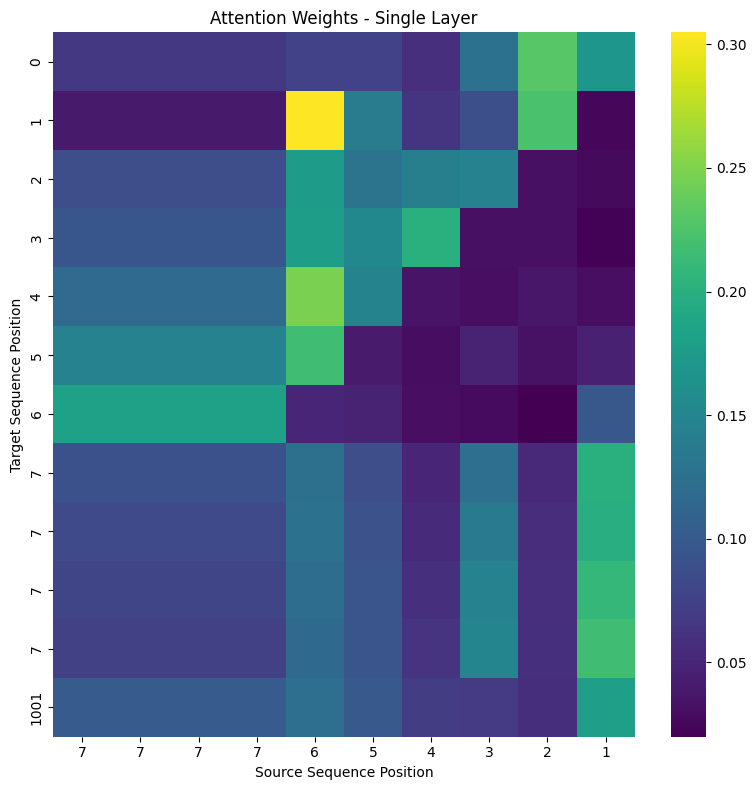

In [ ]:
# Assuming 'attention' contains a single tensor of shape (1, tgt_seq_len, src_seq_len)
attn_weights = attention[0]  # Get the single layer's attention weights

# Squeeze the tensor and convert to NumPy array: (tgt_seq_len, src_seq_len)
attn_weights_np = attn_weights.squeeze(0).detach().cpu().numpy()

# Plot heatmap for the single layer
plt.figure(figsize=(8, 8))  # Adjust figure size as needed
sns.heatmap(attn_weights_np, cmap="viridis", xticklabels=input_tokens, yticklabels=out_put_tokens)
plt.title("Attention Weights - Single Layer")
plt.xlabel("Source Sequence Position")
plt.ylabel("Target Sequence Position")

plt.tight_layout()
plt.show()

In [ ]:
# torch.save(model, "entire_model.pth")

In [ ]:
# model=torch.load( "entire_model.pth",map_location=torch.device(device))

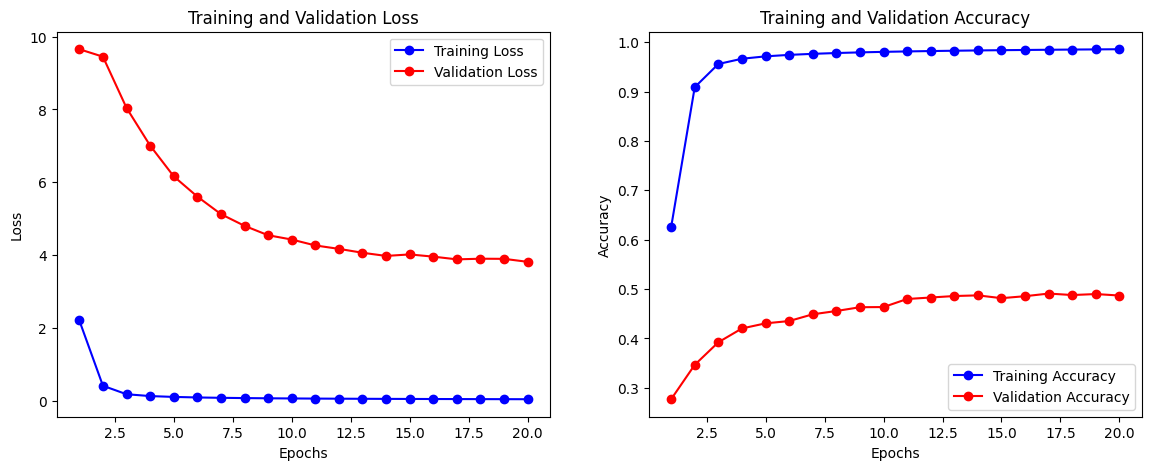

In [ ]:
import matplotlib.pyplot as plt


# Plotting function
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(14, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'ro-', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.show()

plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

In [ ]:
from tqdm import tqdm

n = 1000
n_sorted = None
n_rep = None
max_seq_len = 70
vary_sec_len = False

data = generate_data(n, max_seq_len, vocab_size,vary_sec_len,n_sorted,n_rep)
# data.sort(key=lambda x: len(x[0])
test_loader = DataLoader(data, batch_size=1000, shuffle=True, collate_fn=lambda x: prepare_batch(x, vocab_size))

loss, acc = validate_model(model, val_loader=test_loader, criterion=criterion)
print(f'\nPerformance on generalizing to sequences of max length 70 (trained on 50) is {acc}')


	Validation: 100%|██████████| 1/1 [00:00<00:00,  7.31batch/s, accuracy=0.985, loss=0.0459]


Performance on generalizing to sequences of max length 70 (trained on 50) is 0.985225352112676


In [ ]:
from tqdm import tqdm
n = 1000
n_sorted = None
n_rep = None
max_seq_len = 100
vary_sec_len = False

data = generate_data(n, max_seq_len, vocab_size,vary_sec_len,n_sorted,n_rep)
# data.sort(key=lambda x: len(x[0])
test_loader = DataLoader(data, batch_size=n, shuffle=True, collate_fn=lambda x: prepare_batch(x, vocab_size))
loss, acc = validate_model(model, val_loader=test_loader, criterion=criterion)
print(f'\nPerformance on generalizing to sequences of max length 100 (trained on 50) is {acc}')

	Validation: 100%|██████████| 1/1 [00:00<00:00,  5.62batch/s, accuracy=0.891, loss=0.394]


Performance on generalizing to sequences of max length 70 (trained on 50) is 0.8914158415841584


In [ ]:
import torch
from collections import Counter


# Inference function (autoregressive)
def infer_autoregressive_with_multiplicities(model, input_seq, device, max_len=20):
    model.eval()  # Set the model to evaluation mode

    # Prepare the input sequence (convert to tensor and add <SOS> token at the start)
    input_seq_tensor = torch.tensor(input_seq, dtype=torch.long).unsqueeze(0).to(device)  # Shape: (1, seq_len)
    tgt_input = torch.tensor([0], dtype=torch.long).unsqueeze(0).to(device)  # <SOS> token at the start (Shape: (1, 1))
    predicted_seq = []  # To store the generated sequence

    # Count occurrences of each token in the input sequence
    input_token_counts = Counter(input_seq)
    predicted_token_counts = Counter()  # To track counts of each token in predictions

    # Set max_len to avoid generating more tokens than in input_seq
    if max_len > len(input_seq):
        max_len = len(input_seq)

    with torch.no_grad():  # Disable gradient computation for inference
        for _ in range(max_len):
            # Forward pass: Generate one token at a time
            output, _ = model(input_seq_tensor, tgt_input)  # Shape: (1, seq_len, vocab_size)
            logits = output[:, -1, :]  # Get logits for the last token generated (Shape: (batch_size, vocab_size))

            # Mask out tokens that have been predicted up to their multiplicity in the input
            for token, count in predicted_token_counts.items():
                if count >= input_token_counts[token]:  # Mask token if it reaches its input count
                    logits[0, token] = float('-inf')

            # Get the most probable token from allowed tokens
            next_token = logits.argmax(dim=-1)  # Shape: (batch_size,)
            predicted_token_counts[next_token.item()] += 1  # Track count of predicted token

            # Update tgt_input to include the newly predicted token
            tgt_input = torch.cat([tgt_input, next_token.unsqueeze(0)], dim=1)  # Shape: (batch_size, seq_len + 1)

            # Stop if we encounter the <EOS> token
            if next_token.item() == vocab_size:
                break
            predicted_seq.append(next_token.item())  # Add to the generated sequence

    return predicted_seq

# Test the autoregressive inference with a given unsorted sequence
input_seq = [10,100,200,20,300,50,500]  # Example input sequence

# Inference
sorted_seq = infer_autoregressive_with_multiplicities(model, input_seq, device, max_len=10)
print(f"Input sequence: {input_seq}")
print(f"Predicted sorted sequence: {sorted_seq}")

Input sequence: [10, 100, 200, 20, 300, 50, 500]
Predicted sorted sequence: [10, 20, 50, 100, 200, 300, 500]


We want to see how the vocabulary tokens are embedded by the encoder. We sample a random sequence of max length and vocab size and do the encoding. We would like to see the tokens which represent numbers to be arranged in a way that implies order or proximity. A random arrangement should raise some concerts regarding the design choice to use a fixed vocabulary size embedding layer instead of a linear encoding. Also, I am using the encoded vectors and not the embedding vectors as the latter lacked structure (which is interesting by itself).

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

seq = torch.linspace(0, 1000, steps=100).long()
embedding_matrix = model.embed(seq.to(device).unsqueeze(0)).squeeze(0).detach().cpu().numpy()

# Apply PCA first to reduce to 20 dimensions for more effective t-SNE
pca = PCA(n_components=50)
embedding_matrix_pca = pca.fit_transform(embedding_matrix)

# Apply t-SNE to reduce to 2D for visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
embedding_matrix_tsne = tsne.fit_transform(embedding_matrix_pca)

# Apply UMAP to reduce to 2D for visualization
umap_reducer = umap.UMAP(n_components=2, random_state=42)
embedding_matrix_umap = umap_reducer.fit_transform(embedding_matrix_pca)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Looking at the plots we see some interesting results. The encoded sequence tokens are clustered closely, and we can also see that there exist directions that seem to encode the semantic "increasing numbers"!

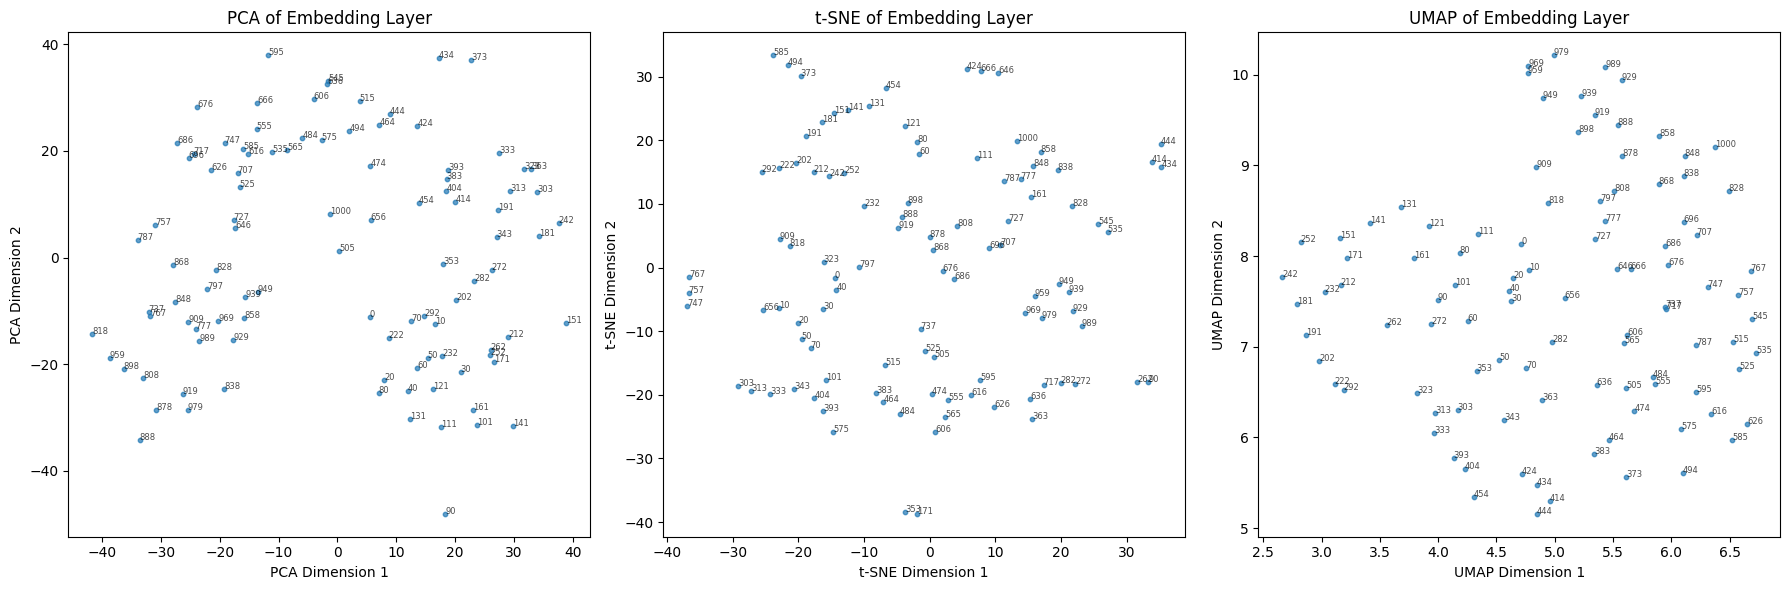

In [ ]:
import matplotlib.pyplot as plt

# Plot the embeddings with labels
plt.figure(figsize=(18, 6))

# PCA 2D plot with labels
plt.subplot(1, 3, 1)
plt.scatter(embedding_matrix_pca[:, 0], embedding_matrix_pca[:, 1], s=10, alpha=0.7)
plt.title("PCA of Embedding Layer")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")

# Label each point with its ID (index in the vocabulary)
for i in range(embedding_matrix_pca.shape[0]):
    plt.text(embedding_matrix_pca[i, 0], embedding_matrix_pca[i, 1], str(seq[i].item()), fontsize=6, alpha=0.7)

# t-SNE 2D plot with labels
plt.subplot(1, 3, 2)
plt.scatter(embedding_matrix_tsne[:, 0], embedding_matrix_tsne[:, 1], s=10, alpha=0.7)
plt.title("t-SNE of Embedding Layer")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")

# Label each point with its ID (index in the vocabulary)
for i in range(embedding_matrix_pca.shape[0]):
    plt.text(embedding_matrix_tsne[i, 0], embedding_matrix_tsne[i, 1], str(seq[i].item()), fontsize=6, alpha=0.7)

# UMAP 2D plot with labels
plt.subplot(1, 3, 3)
plt.scatter(embedding_matrix_umap[:, 0], embedding_matrix_umap[:, 1], s=10, alpha=0.7)
plt.title("UMAP of Embedding Layer")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")

# Label each point with its ID (index in the vocabulary)
for i in range(embedding_matrix_pca.shape[0]):
    plt.text(embedding_matrix_umap[i, 0], embedding_matrix_umap[i, 1], str(seq[i].item()), fontsize=6, alpha=0.7)

plt.tight_layout()
plt.show()